In [1]:
library(DBI)
library(ggplot2)
library(tidyverse)
library(caret)
library(scales)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
✔ purrr   1.0.0      
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift



Attaching package: ‘scales’


The following object is masked from ‘package:purrr’:

    discard


The following object is masked from ‘package:readr’:

    col_factor




In [14]:
mytheme <- function() {
  return(theme_bw() +
           theme(
             # NOTE: UNCOMMENT WHEN RENDING PLOTS FOR THE PAPER
             # (can't get the CM fonts to work in artifact VM...)
             text = element_text(family = "Times", size=10),
              panel.grid.major = element_blank(),
             # panel.grid.minor = element_blank(),
             # panel.grid.major = element_line(colour="gray", size=0.1),
             # panel.grid.minor =
             #  element_line(colour="gray", size=0.1, linetype='dotted'),
             axis.ticks = element_line(size=0.05),
             axis.ticks.length=unit("-0.05", "in"),
             axis.text.y = element_text(margin = margin(r = 5)),
             axis.text.x = element_text(hjust=1),
             legend.key = element_rect(colour=NA),
             legend.spacing = unit(0.001, "in"),
             legend.key.size = unit(0.2, "in"),
             legend.title = element_blank(),
             legend.position = c(0.75, .7),
             legend.background = element_blank()))
}

mysave <- function(filename) {
  ggsave(filename, width=4, height=3, units=c("in"))
  # embed_font(path)
}

In [2]:
con <- dbConnect(
    RPostgres::Postgres(),
    dbname = 'npm_data', 
    user = 'data_analyzer',
)

In [3]:
# This takes about 40 seconds to load (when running on the VM!), and takes about 4GB of memory
df_full <- dbGetQuery(con, "
    select update_from_id, update_to_id, downstream_package_id, (unnest(oldnesses)).* from historic_solver_job_results_oldnesses
    where array_length(oldnesses, 1) is not null
")

In [4]:
df_sub <- df_full[sample(nrow(df_full), 10000),] 

In [5]:
df <- df_full

In [6]:
downstream_oldness_stats <- df %>% 
    group_by(downstream_package_id) %>% 
    summarise(
        n = n(),
        mean_old_secs = mean(as.numeric(old_secs)),
        num_old = sum(old_secs > 10),
        perc_old = num_old / n
    ) %>% arrange(desc(n))

In [7]:
head(downstream_oldness_stats)

downstream_package_id,n,mean_old_secs,num_old,perc_old
<int64>,<int>,<dbl>,<int>,<dbl>
2004852,1641,63550273,869,0.5295551
665858,1630,29832839,731,0.4484663
1636980,1627,15750136,507,0.3116165
1225879,1612,15663530,529,0.3281638
1774393,1595,28624429,656,0.4112853
2213981,1587,18806160,565,0.3560176


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


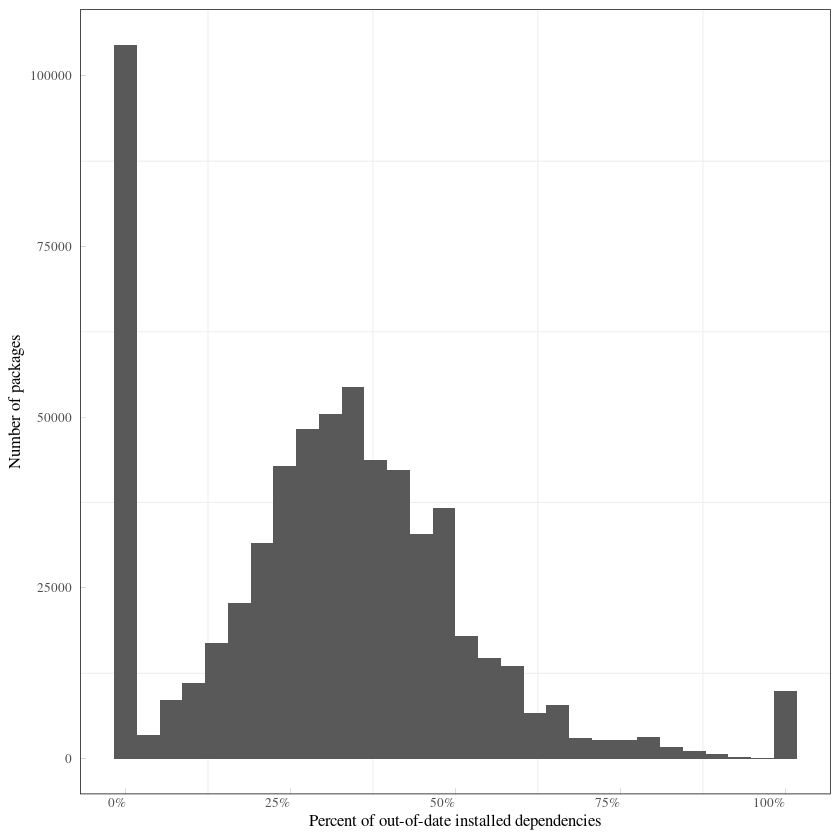

In [30]:

ggplot(data=downstream_oldness_stats, aes(x=perc_old)) + 
    geom_histogram() +
    scale_x_continuous(labels = scales::percent) +
    xlab("Percent of out-of-date installed dependencies") +
    ylab("Number of packages") +
    mytheme()

mysave("plots/rq3/perc_old_hist.pdf")

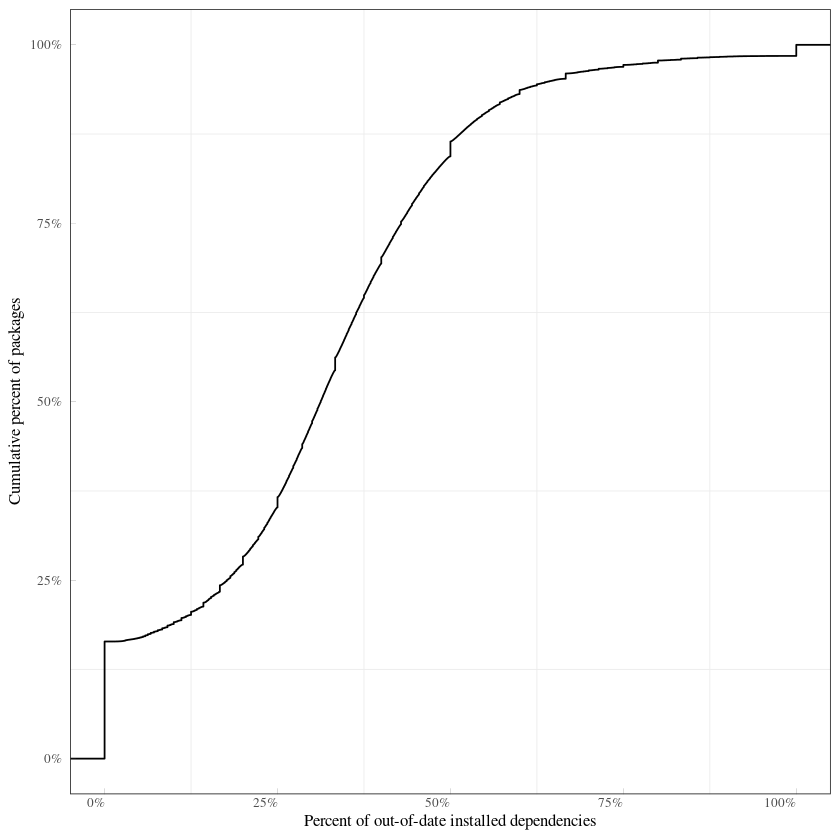

In [31]:
ggplot(data=downstream_oldness_stats, aes(x=perc_old)) + 
    stat_ecdf() +
    scale_x_continuous(labels = scales::percent) +
    scale_y_continuous(labels = scales::percent) +
    xlab("Percent of out-of-date installed dependencies") +
    ylab("Cumulative percent of packages") +
    mytheme()

mysave("plots/rq3/perc_old_ecdf.pdf")

In [22]:
100 * (downstream_oldness_stats %>% filter(perc_old >= 0.25) %>% nrow()) / nrow(downstream_oldness_stats)

[1] 64.81

In [23]:
100 * (downstream_oldness_stats %>% filter(perc_old <= 0) %>% nrow()) / nrow(downstream_oldness_stats)

[1] 16.40875

In [24]:
downstream_oldness_stats %>% summarise(mean(n))

mean(n)
<dbl>
167.8649


In [25]:
downstream_oldness_stats %>% filter(perc_old <= 0) %>% summarise(mean(n))

mean(n)
<dbl>
2.986801


In [27]:
downstream_oldness_stats %>% filter(perc_old > 0) %>% summarise(mean(n))

mean(n)
<dbl>
200.2301


In [28]:
downstream_oldness_stats %>% 
summarise(mean(as.numeric(mean_old_secs))) / (60 * 60 * 24)

mean(as.numeric(mean_old_secs))
<dbl>
179.8937


In [29]:
downstream_oldness_stats %>% 
filter(perc_old > 0) %>% 
summarise(mean(as.numeric(mean_old_secs))) / (60 * 60 * 24)

mean(as.numeric(mean_old_secs))
<dbl>
215.2478
